# Table of contents
* [Introduction](#Introduction)
* [Data](#Data)
    * [Estates for sale dataframe](#Estates)
    * [Venues dataframe](#Venues)
* [Methodology](#Methodology)
* [Results and discussion](#Results)
* [Conclusion](#Conclusion)

# Introduction: Business problem <a name='Introduction'></a>

The goal of this report is to provide some information about neighborhoods of **Savannah, Georgia**. These information, while not trivial to find, are particularly useful for current residents or prospective residents who are thinking of residing in this city, for current city leaders, and investors who wants to have an updates about the city estates and venues.

# Data <a name='Data'></a>  
In this report, we will focus only on two main type of information which are:   
* current estates sale prices (obtained by scraping **Zillow.com**)   
* venues in the city (obtained by using **Foursquare API**) 

For current or prospective residents, estates sale prices information is useful for choosing the houses with adequate living space while still stay within their price range. Then information about venues give the residents an idea about social places density of different neighborhood in the city. This also aid in helping choosing their residing location. On the other hand, an investor might want to use the city venues information to choose the location of their new business which has less competition.

## Data gathering <a name='Data-gathering'></a>

In [2]:
import pandas as pd
import numpy as np
import requests
import urllib.request, urllib.parse, urllib.error
from urllib.request import Request, urlopen
import ssl
from bs4 import BeautifulSoup
import json

# load ploting libraries
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# time library for pausing the program and time call
import time

## Location of interest: Savannah, Georgia <a name="location-of-interest"></a>

In [3]:
# Insert city and state for house for sale search
city = 'Savannah'
state = 'GA'

## Build estates for sale dataframe <a name='Estates'></a>

Create the first sale estate listing web page to scrape for information

In [4]:
# Zillow url format
url = 'https://www.zillow.com/homes/{},-{}_rb/'.format(city, state)
print(url)

https://www.zillow.com/homes/Savannah,-GA_rb/


From examining the html file, the estate listing is under class **"photo-cards photo-cards_wow photo-cards_short"**. Each estate listing is under the anchor tag **'li'**. Let's loops through these anchor tags to extract information about each estate.  
**Note:** Estates those are for rent will be ignore.  
**Note:** Estates to keep are:  
1) for sale    
2) new construction  
3) auction  
4) Foreclosed  

**Instantitiate empty dataframe 1**  
This first data frame contains sale listing type, address and webpage of each estates.

In [4]:
# Columns of for sale estates dataframe
col_names_1 = ['Listing Type', 'Address', 'Website']
# instantitiate the dataframe
df_1 = pd.DataFrame(columns=col_names_1)

### Scrape Zillow.com for estate for sale in Savannah, GA

In [5]:
# Define a function to get html from a url
def get_webpage(url):
    '''Get html webpage from an url.
    param: url = url of a webpage.
    return: a BeaufifulSoup object
    '''
    # make url request
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'})
    html = urlopen(req).read()
    # return a BeautifulSoup object
    return BeautifulSoup(html, 'html.parser')

**Get general estates for sale information**

In [6]:
# keep track of the number of web pages.
page_num = 1

# loop through all the listing links
while True: # there is an estate listing link
    # print page info
    #print('Page number: {}'.format(page_num))
    #print(url)
    
    # create soup object
    soup = get_webpage(url)
    
    estates_lst = soup.find(class_='photo-cards photo-cards_wow photo-cards_short').find_all('li')
    for estate in estates_lst:
        # Check to make sure there is information under a 'li' tag
        if len(estate.find_all(class_='list-card-type')) == 0:
            continue # if no information, move on to the next 'li' tag
        else:
            # get listing type
            list_type = estate.find(class_='list-card-type').text
            # throw out listing which is not the right type
            if ('sale' not in list_type and 
                'New construction' not in list_type and 
                'Auction' not in list_type and
                'Foreclosed' not in list_type):
                continue
            else:
                # get estate address
                addr = estate.find(class_='list-card-addr').text
                # get estate link
                link = estate.find('a').get('href')

            # append information to dataframe
            df_1 = df_1.append({'Listing Type':list_type,
                               'Address':addr,
                               'Website':link}, ignore_index=True)
    # update page count
    page_num += 1
    
    # check if there is a next page. If not
    if soup.find(class_='zsg-pagination-next').find('a') == None:
        break # end while loop
    else:
        # get next listing page
        base_url = 'https://www.zillow.com'
        extension = soup.find(class_='zsg-pagination-next').find('a').get('href')
        url = base_url + extension

**Function that scrape Zillow for details of a estate**

In [10]:
def get_estate_details(soup):
    '''Get details information about an estate.
    param: soup = A BeautifulSoup object
    return: list contains
    '''
    # get sale price
    try:
        price = int(soup.find(class_='ds-value').text.replace("$", '').replace(',', ''))
    except:
        price = 0
    
    # get neighborhood name
    nei = 'nan'
    for item in soup.find_all('h4'): # Neighborhood in one of the anchor tag 'h4'
        if 'Neighborhood' in item.text: # if there is neighborhood information
            nei = item.text.split(':')[1].strip() # return neighborhood name

    # get rooms information
    bd_num = 0
    ba_num = 0
    sqft = 0
    for item in soup.find_all(class_='ds-bed-bath-living-area')[:3]:
        if 'bd' in item.text:
            try: 
                bd_num = int(item.text.split()[0])
            except:
                bd_num # In no bedroom data available, set bedroom = default value
        elif 'ba' in item.text:
            try:
                ba_num = int(item.text.split()[0])
            except:
                ba_num # In no bathroom data available, set bathroom = default value
        elif 'sqft' in item.text:
            try:
                sqft = int(item.text.split()[0].replace(',', ''))
            except:
                sqft # In no sqft data available, set sqft = default value
    
    # get estate detail information
    estate_type = 'nan'
    year = 0
    heat = 'nan'
    cool = 'nan'
    park = 'nan'
    lot_size = 0
    for item in soup.find(class_='ds-home-fact-list'):
        info = item.text.split(':')
        if 'Type' in info[0]:
            estate_type = info[1]
        elif 'Year built' in info[0]:
            try:
                year = int(info[1])
            except:
                year # In no year built data available, set year built = default value
        elif 'Heating' in info[0]:
            heat = info[1]
        elif 'Cooling' in info[0]:
            cool = info[1]
        elif 'Parking' in info[0]:
            try:
                park = int(info[1].split()[0])
            except:
                park = 0 # In no parking data available, set number of parking = 0
        elif 'Lot' in info[0]:
            try:
                lot_size = int(info[1].split()[0].replace(',', ''))
            except:
                lot_size # In no lot size data available, set lot size = default value

    # get nearby school and school rating
    # list of schools:
    schools_lst = soup.find_all(class_='ds-school-row')
    schools_name = []
    ratings = []
    grades = []
    for school in schools_lst:
        # get school rating. Max score = 10. Concatinate string together
        ratings.append(school.find(class_='ds-school-rating').text.split('/')[0])
        # get school name
        schools_name.append(school.find(class_='ds-nearby-schools-info-section').find('a').text)
        # get grade of school
        grades.append(school.find(class_='ds-school-value ds-body-small').text)
    
    return [price, estate_type, nei, bd_num, ba_num, 
            sqft, year, heat, cool, park, 
            lot_size, ', '.join(schools_name), ', '.join(grades), ', '.join(ratings)]

**Instantitiate empty dataframe 2**  
This second data frame contains details information about each estate for sale. Those information are price, estate type, neighborhood in, number of beds, number of bathrooms, square feet, year built, heating, cooling, number of parking spaces, lot size, nearby schools, school grades, and nearby school ratings.

In [11]:
# Columns of for sale estates dataframe
col_names_2 = ['Price', 'Estate Type', 'Neighborhood', 'Beds', 'Bath', 
               'Sqft', 'Year Built', 'Heating', 'Cooling', 'Parking', 
               'Lot Size', 'Schools', 'School Grades', 'School Ratings']
# instantitiate the dataframe
df_2 = pd.DataFrame(columns=col_names_2)

**Add data to dataframe 2**

In [12]:
for weblink in df_1['Website']:
    #print('Page: {}, {}'.format(page_count, weblink))
    soup = get_webpage(weblink)
    estate_details = get_estate_details(soup)
    df_2 = df_2.append(pd.Series(estate_details, index=df_2.columns ), ignore_index=True)
    # Wait 5 seconds before requesting next page to prevent access being blocked
    time.sleep(5)

TypeError: 'NoneType' object is not iterable

**Now we can concatenate two dataframes together for a complete dataframe of for sale estates in Savannah, GA**
After obtaining one dataframe of estates for sale in Savannah, and another dataframe for estates' detail information, we can now combine the two dataframe into one final estates for sale dataframe.

In [ ]:
df_estates = pd.concat([df_1,df_2], axis=1)

Drop rows with duplicated address

In [ ]:
df_estates.drop_duplicates(subset='Address', keep='first', inplace=True)

The dataframe is written to a csv file for later easier accessing the data without having to scrape the web again.

In [37]:
# Write to file 
df_estates.to_csv('estates_Savannah_GA_(clean).csv',index=False)

## Build neighborhood information dataframe
This dataframe contains general information about neighborhood geographic: 1) Region ID, 2) coordinates and estate pricing information: 3) Zillow Home Value Index.  
The data will be obtained from Zillow using API calls.

**First, instantitiate the dataframe**

In [ ]:
# Columns of for sale estates dataframe
col_names_3 = ['Id', 'Neighborhood', 'Zillow index', 'Latitude', 'Longitude', 'Website']
# instantitiate the dataframe
df_neighborhood = pd.DataFrame(columns=col_names_3)

**Prepare Zillow API request**

In [ ]:
API_source = 'https://www.zillow.com/webservice/GetRegionChildren.htm'
# ID to use Zillow API
zwsid = 'X1-ZWz1hgj59tqmff_55f1z'
# The type of subregions to retrieve (available types: state, county, city, zipcode, and neighborhood).
childtype = 'neighborhood'
# build inquiry string
inquiry = '?zws-id={}&state={}&city={}&childtype={}'.format(zwsid, state, city, childtype)
url = API_source + inquiry

**Get data from Zillow, xml format**

In [ ]:
xml = urllib.request.urlopen(url).read()
soup = BeautifulSoup(xml, 'xml')

**Insert into dataframe**

In [ ]:
# find geographic data of neighborhoods
for region in soup.find('list').find_all('region'):
    df_neighborhood = df_neighborhood.append({'Id':region.find('id').text,
                       'Neighborhood':region.find('name').text,
                       'Latitude':region.find('latitude').text,
                       'Longitude':region.find('longitude').text,
                       'Website':region.find('url').text}, ignore_index=True)

In [ ]:
# find Zillow home value index for each neighborhoods
index = 0
for link in df_neighborhood['Website']:
    #print('Page {}, link: {}'.format(index+1, link))
    # create soup object from a url
    soup = get_webpage(link)
    try:
        v = soup.find(class_='region-info-item').find('h2').text
    except:
        v = 0
        # if there is no data, print out the url
        print('---------------------------------------')
        print('Page {}, link: {}'.format(index+1, link))
        print('------------------------------------------')
    try:
        v = int(v.replace('$', '').replace(',', ''))
    except:
        v = 0
    df_neighborhood.at[index, 'Zillow index'] = v
    index += 1
    # sleep for 10 seconds after each loop to avoid website access denied
    time.sleep(10)

In [ ]:
# write to file
df_neighborhood.to_csv('df_neighborhood.csv', index=False)

## Build venues dataframe <a name='Data-gathering'></a>

In [614]:
# get neighborhood coordinates data, which was obtained before.
df_neighborhood = pd.read_csv('df_neighborhood.csv', header=0)
# drop unecessary columns
df_neighborhood.drop(['Id', 'Website', 'Zillow index'], axis='columns', inplace=True)

In [615]:
df_neighborhood.head()

,Neighborhood,Latitude,Longitude
0,Georgetown,31.966999,-81.218094
1,Wilshire Estates/Savannah Mall/Tranquilla Woods,31.987075,-81.154211
2,Windsor Forest,31.964880,-81.160303
3,Teal Lake/Gateway Village/South Oaks/Canebreak,31.997683,-81.279621
4,Bradley Pointe South Area,31.982266,-81.264424


#### We will use Foursquare to gather information about venues around each neighborhoods in Savannah
Input your Foursquare client ID and secret and version

In [352]:
# Your Foursquare client ID
CLIENT_ID = 'your client ID'
# Your Foursquare client secret
CLIENT_SECRET = 'your client secret'
# Version of Foursquare
VERSION = '20180605'
LIMIT = 100 # Maximum number of venues being returned

**Creat a function to which calls Foursquare to gather venues information within 500 meter of location and build a dataframe.**

In [585]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**Use the function above to create a dataframe of venues in Savannah**

In [616]:
df_venues = getNearbyVenues(names=df_neighborhood['Neighborhood'],
                                   latitudes=df_neighborhood['Latitude'],
                                   longitudes=df_neighborhood['Longitude']
                                  )

Georgetown
Wilshire Estates/Savannah Mall/Tranquilla Woods
Windsor Forest
Teal Lake/Gateway Village/South Oaks/Canebreak
Bradley Pointe South Area
Live Oak
Leeds Gate/Colonial Village/Hunters Chase
White Bluff Neighborhoods
Liberty City/Summerside/Southover/Richfield
South Historic District
Chatham Parkway
West Savannah
Hunter Army Airfield
Ardsley Park/Chatham Crescent
Paradise Park
The Village/Rio/Armstrong
Ardmore/Gould Estates/Olin Heights
Brookview/Skidway Terrace/Parkview
Cuyler/Brownville
Midtown
Godley Station
Tatemville
Oakhurst
Avondale
Laroche Park
Carver Heights
Laurel Grove/Railroad Area
Thomas Square
Victory Heights
Savannah State/Glynwood/Placentia Plantation/Brentwood/DeRenne
Bacon Park Area/Sandfly
Metropolitan
Eastside
Abercorn Heights/Lamara Heights/Ridgewood/Poplar Heights
Oakdale
Coffee Bluff/Rose Dhu
Cloverdale
North Historic District
Benjamin Van Clark Park
Largo Woods/Quail Forest
Forest Hills
Baldwin Park
Lynhurst/Rivers End
Highland Park
Sweetwater Plantation


In [617]:
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Georgetown,31.966999,-81.218094,Savannah Concrete Contractors,31.970030,-81.221072,Home Service
1,Wilshire Estates/Savannah Mall/Tranquilla Woods,31.987075,-81.154211,Redbox,31.982732,-81.152879,Video Store
2,Wilshire Estates/Savannah Mall/Tranquilla Woods,31.987075,-81.154211,Sbarro,31.983906,-81.152970,Pizza Place
3,Wilshire Estates/Savannah Mall/Tranquilla Woods,31.987075,-81.154211,Southside YMCA,31.986233,-81.152697,Gym / Fitness Center
4,Wilshire Estates/Savannah Mall/Tranquilla Woods,31.987075,-81.154211,Cloud9 Medical Spa,31.987287,-81.151505,Spa


In case there happens to have a venue category named 'Neighborhood', replace that venue category to 'Locality' to avoid confusion with column name 'Neighborhood'

In [618]:
df_venues.loc[df_venues['Venue Category']=='Neighborhood', ['Venue Category']] = 'Locality'

Write venues dataframe to file for storage and further analysis

In [619]:
df_venues.to_csv('df_venues.csv', index=0)

# Methodology <a name='Methodology'></a>
After obtaining the necessary data, we now proceed to exploratory data analysis.  
First, we will map out the physical location of each neighborhoods in Savannah, Georgia to have an idea of their locations.  
Second, we will analyze the popularity of different type of venues in the city by looking at the venues density in each neighborhood. We will do this using **k-mean clustering** and **heat map**.  
Similarly, we will analyze the estates sale prices in different neighborhoods in the city. We will first look at a the average estates sale prices in each neighborhoods using **bar chart**, **box plot**, and **heat map**. We will attempt to cluster the neighborhood based on estate information **(price, number of beds, bathrooms, square feet, year built)**. One important factor when choosing a residing location for a family with childrens is the quality of nearby schools. Therefore, we will examine to see if the ratings of nearby schools correlate with estates sale prices.

## Data analysis <a name="Data-analysis"></a>

### Map neighborhoods in Savannah, GA
**Note:** Neighborhood geospatial data were obtained from Savannah Area Geographic Information System (SAGIS) at sagis.org. Useful keywords to use when searching for neighborhood boundaries data are: *shapefile* and *geojson*.

Load neighborhood dataframe obtained in the data gathering section

In [4]:
df_neighborhood = pd.read_csv('df_neighborhood.csv', header=0)

In [5]:
# Savannah coordinates
latitude = 32.0587665
longitude = -81.1503643

# create map of Savannah using latitude and longitude values
map_savannah = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df_neighborhood['Latitude'], df_neighborhood['Longitude'], df_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='red',
        popup=label,
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(map_savannah)  

map_savannah

## Part 2-1: Venues analysis
First, load venues dataframe obtained in previous steps

In [6]:
df_venues = pd.read_csv('df_venues.csv', header=0)

Check to see how many venues are in the dataframe

In [7]:
print('Number of venues: {}'.format(df_venues.shape[0]))

Number of venues: 792


Check to the number of unique venue categories

In [8]:
print('Number of venues categories: {}'.format(len(df_venues['Venue Category'].unique())))

Number of venues categories: 197


### Analyze Savannah venues in details

In [9]:
# one hot encoding
venues_onehot = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = df_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Winery,Women's Store,Yoga Studio
0,Georgetown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wilshire Estates/Savannah Mall/Tranquilla Woods,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,Wilshire Estates/Savannah Mall/Tranquilla Woods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wilshire Estates/Savannah Mall/Tranquilla Woods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wilshire Estates/Savannah Mall/Tranquilla Woods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###  Analyze the popularity of a venue category in each neighborhoods of Savannah.  
The popularity of a venue category is represented by the average occurrence of that category over the total number of venues in a neighborhood.

In [10]:
venues_grouped = venues_onehot.groupby('Neighborhood').mean().reset_index()
print('Number of neighborhoods: {}'.format(venues_grouped.shape[0]))
venues_grouped.head()

Number of neighborhoods: 84


,Neighborhood,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,...,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Winery,Women's Store,Yoga Studio
0,Abercorn Heights/Lamara Heights/Ridgewood/Popl...,0.000000,0.000000,0.0,0.133333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Ardmore/Gould Estates/Olin Heights,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,Ardsley Park/Chatham Crescent,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Avalon/Oglethorpe Mall,0.020833,0.020833,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020833,0.0
4,Avondale,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### Pick out the top 5 venue category in each neighborhood of Savannah

Create a function to sort values in each row

In [11]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:] # ignore the 1st column which is the Neighborhood column
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new sorted dataframe of top 5 venue categories in each neighborhood

In [12]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
# The first column is 'Neighborhood'
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_top5 = pd.DataFrame(columns=columns)
venues_top5['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    venues_top5.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

venues_top5.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abercorn Heights/Lamara Heights/Ridgewood/Popl...,American Restaurant,Coffee Shop,Camera Store,Grocery Store,Bakery
1,Ardmore/Gould Estates/Olin Heights,Park,Baseball Field,Yoga Studio,French Restaurant,Fountain
2,Ardsley Park/Chatham Crescent,Plaza,Food,Pet Store,Greek Restaurant,Park
3,Avalon/Oglethorpe Mall,Cosmetics Shop,Lingerie Store,Furniture / Home Store,Fast Food Restaurant,Department Store
4,Avondale,Cuban Restaurant,Dog Run,Park,Farm,Music Venue


### Cluster the neighborhood based on venues

We will cluster the neighborhood using K-means method. First we need to determine the best number of k to use. This will be done using the elbow method

**Elbow method**  
*Distortion:* It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the Euclidean distance metric is used.  
*Inertia:* It is the sum of squared distances of samples to their closest cluster center.

In [13]:
# prepare dataframe for k-means
venues_grouped_clustering = venues_grouped.drop('Neighborhood', 1)

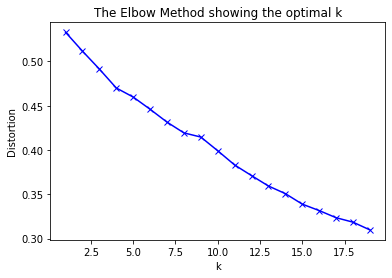

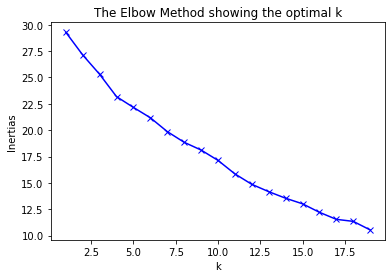

In [14]:
# k means determine k
distortions = []
inertias = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(venues_grouped_clustering)
    kmeanModel.fit(venues_grouped_clustering)
    distortions.append(sum(np.min(cdist(venues_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / venues_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Plot the elbow
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertias')
plt.title('The Elbow Method showing the optimal k')
plt.show()

From the above plots, it seems that there is no clear clustering in the city venues popularity data. Although the elbow is not obvious, we can see that there is evidence of an elbow in the inertias plot at k = 4. Therefore, I will choose k = 4 for further analysis.

In [15]:
# k means using k = 4
kclusters = 4
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeanModel.labels_[0:10] 

array([1, 0, 1, 1, 1, 3, 0, 1, 1, 1])

Create a new dataframe with cluster labels and the top 5 venue categories

In [16]:
# add clustering labels
venues_top5.insert(0, 'Cluster Labels', kmeanModel.labels_)

venues_merged = df_neighborhood

# merge toronto_grouped with toronto to add latitude/longitude for each neighborhood
venues_merged = venues_merged.join(venues_top5.set_index('Neighborhood'), on='Neighborhood')

# in case some neighborhood has no venues around.
# Remove those neighborhood from the dataframe.
venues_merged['Cluster Labels'] = venues_merged['Cluster Labels'].astype(str)
venues_merged = venues_merged[venues_merged['Cluster Labels'] != 'nan']
venues_merged['Cluster Labels'] = venues_merged['Cluster Labels'].astype(float).astype(int)

venues_merged.head()

,Id,Neighborhood,Zillow index,Latitude,Longitude,Website,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,128864,Georgetown,174200,31.966999,-81.218094,http://www.zillow.com/local-info/GA-Savannah/G...,2,Home Service,Yoga Studio,Electronics Store,French Restaurant,Fountain
1,763632,Wilshire Estates/Savannah Mall/Tranquilla Woods,126000,31.987075,-81.154211,http://www.zillow.com/local-info/GA-Savannah/W...,1,Gym / Fitness Center,Spa,Pizza Place,Video Store,Asian Restaurant
2,132788,Windsor Forest,163300,31.964880,-81.160303,http://www.zillow.com/local-info/GA-Savannah/W...,1,Outdoors & Recreation,Yoga Studio,Furniture / Home Store,French Restaurant,Fountain
3,764334,Teal Lake/Gateway Village/South Oaks/Canebreak,139800,31.997683,-81.279621,http://www.zillow.com/local-info/GA-Savannah/T...,1,Motel,Hotel,Yoga Studio,Farm,French Restaurant
4,763639,Bradley Pointe South Area,180900,31.982266,-81.264424,http://www.zillow.com/local-info/GA-Savannah/B...,1,Gym,Yoga Studio,French Restaurant,Fountain,Food Truck


**Map neighborhood by their group**

In [17]:
# Savannah coordinates
latitude = 32.0587665
longitude = -81.1503643

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venues_merged['Latitude'], venues_merged['Longitude'], venues_merged['Neighborhood'], venues_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [18]:
# out of all the 1st most common venues in each neighborhood, we will plot only the top 15 most common venues.
# create a list of top 15 most common venues
col = venues_merged.groupby('1st Most Common Venue') \
                    .count() \
                    .sort_values(by='Neighborhood',ascending=False) \
                    .reset_index() \
                    .head(15)['1st Most Common Venue'] \
                    .tolist()

# instatantiate new dataframe for bar plot
ind = sorted(venues_merged['Cluster Labels'].unique())
df_clusters_bar = pd.DataFrame(columns = col, index = ind)

for cluster in ind:
    for venue_type in col:
        val = venues_merged[(venues_merged['Cluster Labels']==cluster) & 
                            (venues_merged['1st Most Common Venue']==venue_type)].count()['Neighborhood']
        # update value to dataframe
        df_clusters_bar.loc[cluster, venue_type] = val        

We can examine the most common venue type in each neighborhood clusters to determine their characteristics

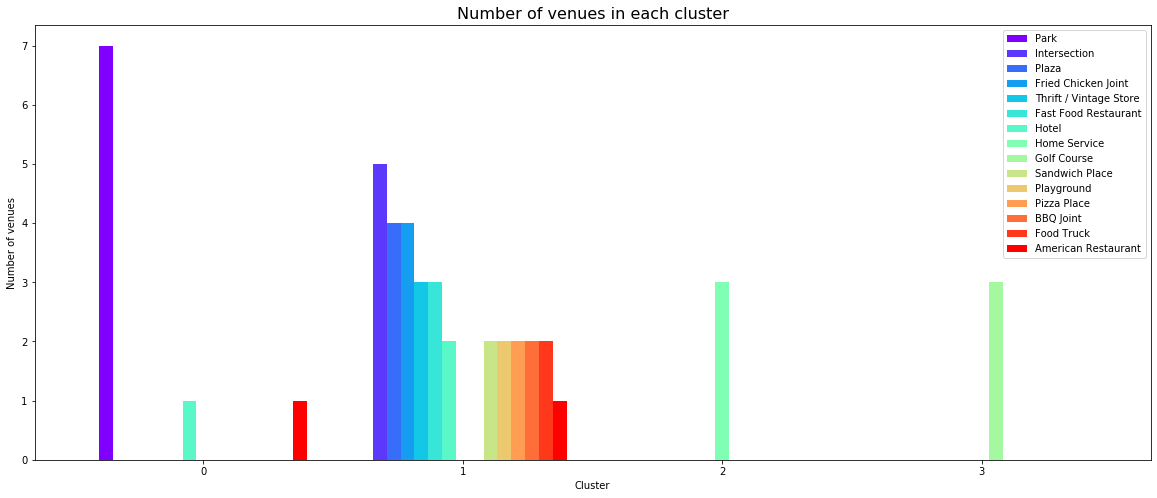

In [19]:
# set color scheme for the clusters
num_colors = df_clusters_bar.shape[1]
x = np.arange(num_colors)
ys = [i + x + (i*x)**2 for i in range(num_colors)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

ax = df_clusters_bar.plot(kind='bar',
                      figsize=(20,8),
                      width=0.8,
                      color=rainbow
                       )

ax.set_title("Number of venues in each cluster", fontsize=16)
plt.rcParams.update({'font.size': 14})
ax.set_xlabel('Cluster')
ax.set_xticklabels(df_clusters_bar.index, rotation='horizontal')
ax.set_ylabel('Number of venues')

plt.show()

From the above plot, each cluster of neighborhoods can be labeled as:  
Clustered 0: parks.  
Clustered 1: food and social venues.   
Clustered 2: home service.  
Clustered 3: Golf course

**Choropleth map of total venues each neighborhood**

First, prepare total venues data of each neighborhood for choropleth map

In [20]:
venues_tot = df_venues.groupby(['Neighborhood']).count()[['Venue']]
venues_tot.reset_index(inplace=True)
venues_tot.rename(columns={'Venue':'Count'}, inplace=True)
venues_tot.head()

,Neighborhood,Count
0,Abercorn Heights/Lamara Heights/Ridgewood/Popl...,15
1,Ardmore/Gould Estates/Olin Heights,4
2,Ardsley Park/Chatham Crescent,5
3,Avalon/Oglethorpe Mall,48
4,Avondale,5


Map total venue data
*Note:* Savannah neighborhood boundaries geojson file was obtained from Savannah Area GIS Open Data.  
Link: https://opendata.arcgis.com/datasets/f6124ade9eba4ecfa61a16c69431c8f8_10.geojson

In [22]:
# read geojson file
savannah_geo = r'Savannah_Neighborhoods.geojson'

# create a numpy array of length 6 and has linear spacing from the minium total venue count 
# to the maximum total venue count.
threshold_scale = np.linspace(venues_tot['Count'].min(),
                              venues_tot['Count'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# Savannah, GA latitude and longitude values
latitude = 32.0587665
longitude = -81.1303643

# create map and display it
savannah_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map using the total venues in each neighborhood
savannah_map.choropleth(
    geo_data=savannah_geo,
    data=venues_tot,
    columns=['Neighborhood', 'Count'],
    key_on='feature.properties.NAME',
    #threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Number of venues in Savannah',
    reset=True
)

# display map
savannah_map

From the choropleth map above, most of venues populated in central downtown Savannah area with the most venue-populated neighborhood being the 'North Historic District'.

## Part 2-2: Estates pricing analysis

Load data for analysis

In [23]:
df_estates = pd.read_csv('estates_Savannah_GA_(clean).csv', header=0)

In [24]:
# drop columns not needed for analysis
df_estates.drop(['Listing Type', 'Address', 'Website'], axis='columns', inplace=True)
df_estates.head()

,Price,Estate Type,Neighborhood,Beds,Bath,Sqft,Year Built,Heating,Cooling,Parking,Lot Size,Schools,School Grades,School Ratings
0,199000,Single Family,Laroche Park,3,2,1562,1956,Forced air,Central,7.0,8712,Low Elementary School,PK-11,2
1,154900,Single Family,Victory Heights,3,2,1370,1957,Heat pump,No Data,2.0,7840,"Shuman Elementary School, Hubert Middle School...","PK-5, 6-8, 9-12","2, 2, 4"
2,135000,Townhouse,Godley Station,2,2,1247,2006,Forced air,Central,0.0,1742,"Godley Station School, Groves High School","PK-8, 9-12","5, 2"
3,262078,Single Family,Godley Station,5,3,2888,2019,Heat pump,Central,0.0,8145,"Godley Station School, Groves High School","PK-8, 9-12","5, 2"
4,254900,Single Family,Godley Station,4,3,2680,2011,Other,Central,0.0,9583,"Godley Station School, Groves High School","PK-8, 9-12","5, 2"


### Average current estate sale price in each neighborhood

In [25]:
# drop row which doesn't have price information
price = df_estates[df_estates.Price != 0]

Create data frame of mean estate sale price of each neighborhood

In [26]:
mean_price = price.groupby(['Neighborhood']).mean()[['Price']]
mean_price.reset_index(inplace=True)
mean_price.rename(columns={'Price':'Mean Price'}, inplace=True)
mean_price.head()

,Neighborhood,Mean Price
0,Abercorn Heights/Lamara Heights/Ridgewood/Popl...,249582.600000
1,Ardmore/Gould Estates/Olin Heights,343776.470588
2,Ardsley Park/Chatham Crescent,488216.421053
3,Avalon/Oglethorpe Mall,650000.000000
4,Avondale,208755.142857


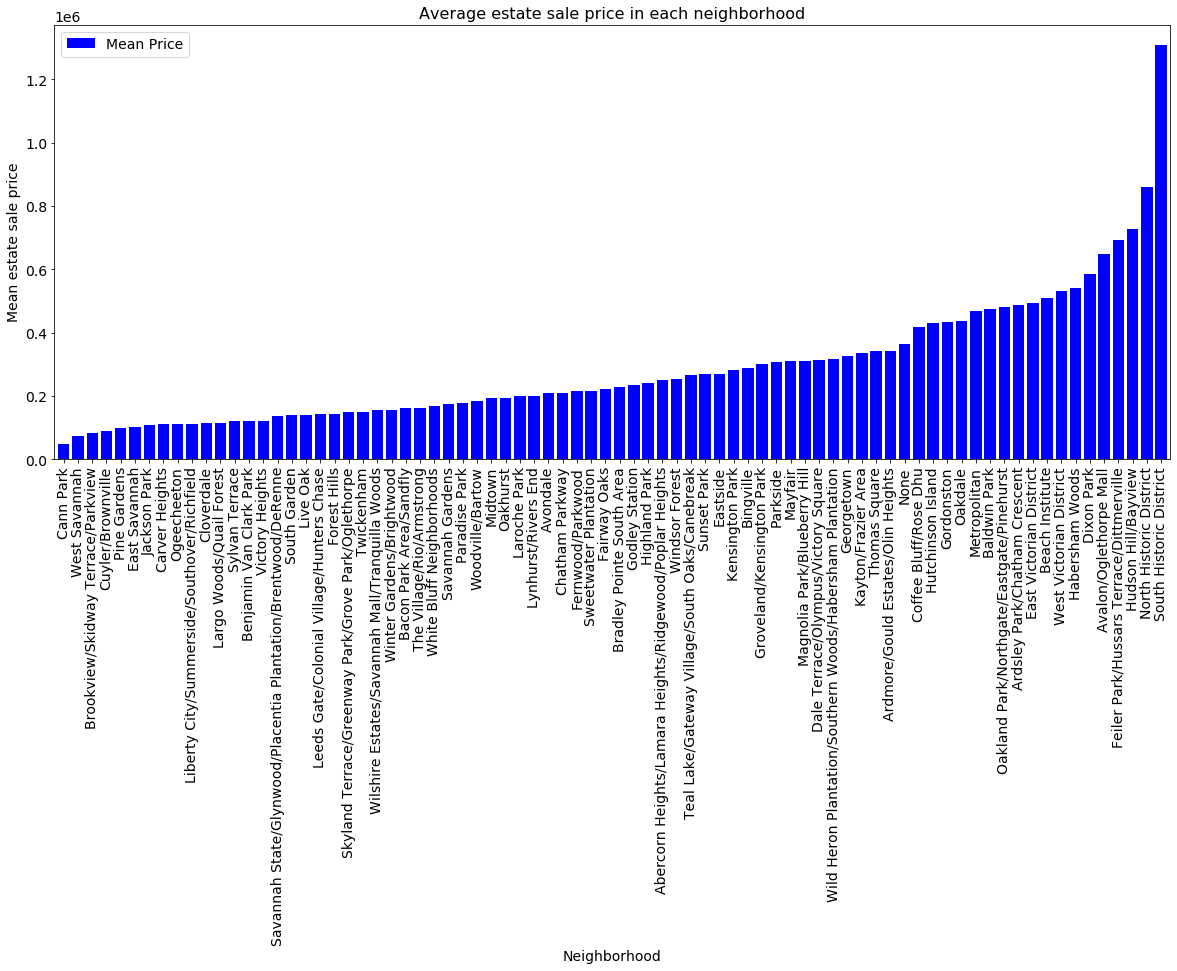

In [27]:
ax = mean_price.sort_values('Mean Price').plot(kind='bar',
                     x='Neighborhood',
                     y='Mean Price',
                      figsize=(20,8),
                      width=0.8,
                      color='b'
                       )

ax.set_title("Average estate sale price in each neighborhood", fontsize=16)
plt.rcParams.update({'font.size': 14})
ax.set_xlabel('Neighborhood')
#ax.set_xticklabels(df_clusters_bar.index, rotation='horizontal')
ax.set_ylabel('Mean estate sale price')
# change y-axis to scientific notation
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#plt.savefig('test.jpeg', quality=95)
plt.show()

**Look at estate price in detail**

In [28]:
#Dataframe for price box plot
# initiate a list of series to be used for generating dataframe later.
lst_df = []
index = 0
# use neighborhoods in mean_price dataframe because they can be sorted by mean values.
# the new dataframe will be sorted by mean values of price
for nei in mean_price.sort_values('Mean Price')['Neighborhood']:
    d = pd.DataFrame(price[price['Neighborhood']==nei]['Price'])
    d.reset_index(inplace=True, drop=True)
    if index == 0:
        df_price_box = d
    else:
        df_price_box = pd.concat([df_price_box, d], ignore_index=True, axis=1)
    index += 1
# label columns of dataframe
df_price_box.columns = mean_price.sort_values('Mean Price')['Neighborhood'].tolist()
df_price_box.head()

,Cann Park,West Savannah,Brookview/Skidway Terrace/Parkview,Cuyler/Brownville,Pine Gardens,East Savannah,Jackson Park,Carver Heights,Ogeecheeton,Liberty City/Summerside/Southover/Richfield,...,East Victorian District,Beach Institute,West Victorian District,Habersham Woods,Dixon Park,Avalon/Oglethorpe Mall,Feiler Park/Hussars Terrace/Dittmerville,Hudson Hill/Bayview,North Historic District,South Historic District
0,49500.0,90000.0,99900.0,68500.0,130900.0,69118.0,110000.0,319900.0,112041.0,235000.0,...,589000.0,284000.0,292000.0,355333.0,420000.0,650000.0,135000.0,1375000.0,3450000.0,475000.0
1,NaN,54000.0,125000.0,60000.0,69000.0,137900.0,NaN,44097.0,NaN,96604.0,...,599000.0,349900.0,225000.0,729900.0,548000.0,NaN,50000.0,79000.0,995000.0,699000.0
2,NaN,35981.0,29900.0,49900.0,NaN,NaN,NaN,39900.0,NaN,109900.0,...,295900.0,629900.0,295000.0,NaN,659000.0,NaN,2500000.0,NaN,470000.0,539000.0
3,NaN,18000.0,NaN,38000.0,NaN,NaN,NaN,39881.0,NaN,10000.0,...,NaN,680900.0,674900.0,NaN,554000.0,NaN,87000.0,NaN,619000.0,3700000.0
4,NaN,175000.0,NaN,75000.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,599900.0,1175000.0,NaN,749900.0,NaN,NaN,NaN,460000.0,2225000.0


<function matplotlib.pyplot.show(*args, **kw)>

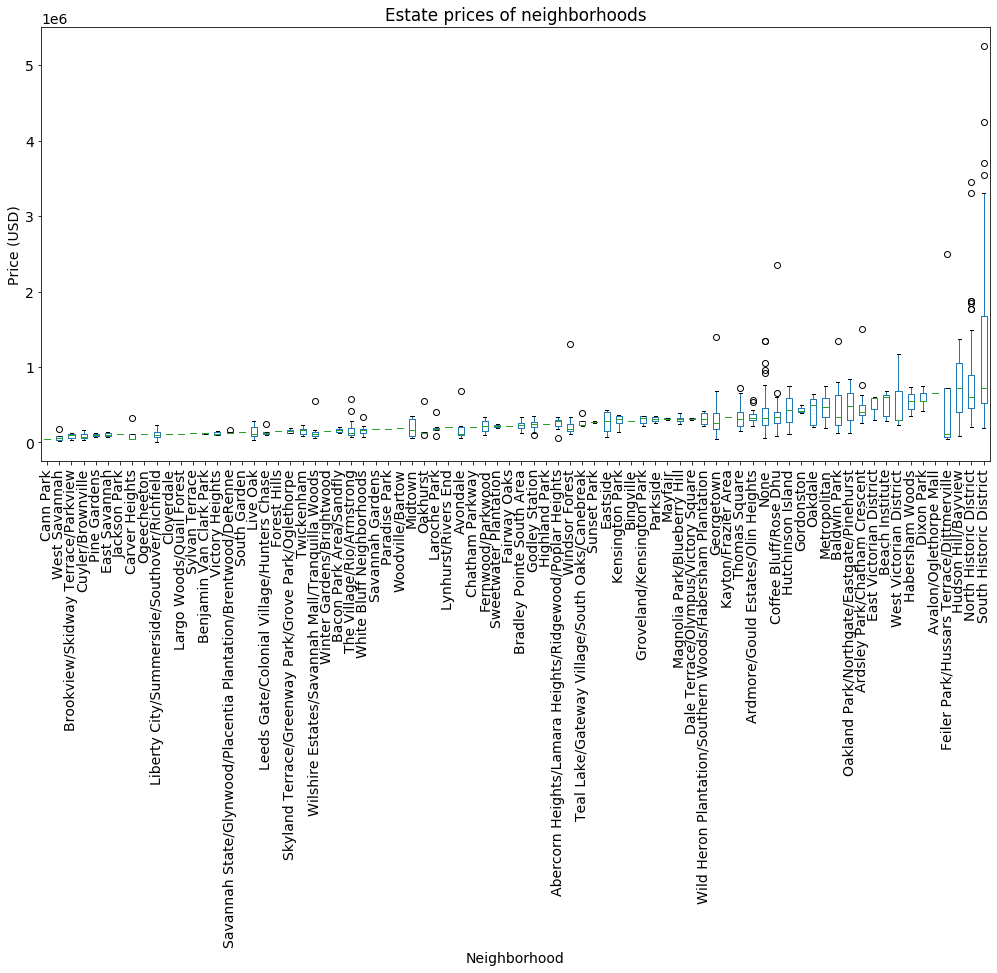

In [68]:
ax = df_price_box.plot(kind='box',
                      figsize=(17,8)
                      )
ax.set_xticklabels(df_price_box.columns, rotation='vertical')
ax.set_xlabel('Neighborhood')
ax.set_ylabel('Price (USD)')
ax.set_title('Estate prices of neighborhoods')
# change y-axis to using scientific notation
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show

From the box-plot above, note that the estate sale price is highly spread for neighborhoods with high average estate sale prices, such as Hudson Hill/Bayview, North Historic Distric, and South Historic Distric.

**Choropleth map of average estate sale price each neighborhood**

map mean estate sale price of each neighborhood

In [30]:
# read geojson file
savannah_geo = r'Savannah_Neighborhoods.geojson'

# create a numpy array of length 7 and has linear spacing from the minium total venue count 
# to the maximum total venue count.
threshold_scale = np.linspace(mean_price['Mean Price'].min(),
                              mean_price['Mean Price'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# Savannah, GA latitude and longitude values
latitude = 32.0587665
longitude = -81.1303643

# create map and display it
savannah_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# generate choropleth map using the total venues in each neighborhood
savannah_map.choropleth(
    geo_data=savannah_geo,
    data=mean_price,
    columns=['Neighborhood', 'Mean Price'],
    key_on='feature.properties.NAME',
    #threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Mean estate sale price in Savannah',
    reset=True
)

# display map
savannah_map

From the mean price choropleth map, the most expensive estates locate at central downtown Savannah, in the 'South Historic District' and 'North Historic District'. No other clear geo-pattern of estate sale price appears. This is in agreement with venue cluster results, where neighborhoods in cluster group 1 (the majority group with the most variety of venues category) also seems to distribute homogeneous in Savannah area.

### Kmeans clustering based on estate
Kmeans grouping of neighborhood based on price, number of bed, number of bath, sqft, year built, average school rating

In [31]:
# drop rows which don't have data about price, beds, bath, and sqft
estates_new = df_estates[(df_estates.Price != 0) \
                         & (df_estates.Beds != 0) \
                         & (df_estates.Bath != 0) \
                         & (df_estates.Sqft != 0) \
                         & (df_estates['Year Built'] != 0)]

In [32]:
# prepare data for kmeans
estates_grouped = estates_new.groupby(['Neighborhood']).mean()[['Price', 'Beds', 'Bath', 'Sqft', 'Year Built']]
estates_grouped.reset_index(inplace=True)
estates_grouped_clustering = estates_grouped.drop('Neighborhood', axis=1)

In [33]:
estates_grouped_clustering.head()

,Price,Beds,Bath,Sqft,Year Built
0,249582.600000,3.000000,1.800000,1617.800000,1951.900000
1,343776.470588,3.235294,2.294118,1975.294118,1948.000000
2,488216.421053,3.473684,2.894737,2666.578947,1932.105263
3,650000.000000,3.000000,1.000000,1583.000000,1962.000000
4,208755.142857,3.428571,2.142857,2143.142857,1941.428571


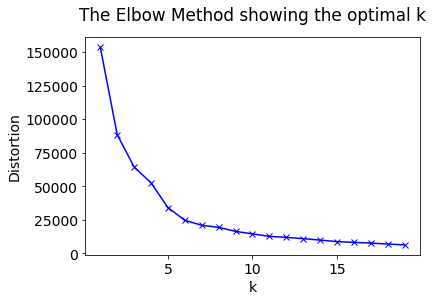

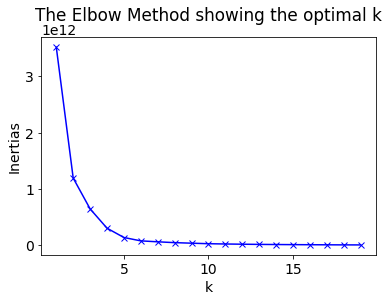

In [69]:
# k means determine k
distortions = []
inertias = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(estates_grouped_clustering)
    kmeanModel.fit(estates_grouped_clustering)
    distortions.append(sum(np.min(cdist(estates_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / estates_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k', y=1.05)
plt.show()

# Plot the elbow
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertias')
plt.title('The Elbow Method showing the optimal k', y=1.05)
plt.show()

From the Inertias plot, the optimal value of k is 5

In [35]:
# k means using k = 5
kclusters = 5
kmeanModel = KMeans(n_clusters=kclusters, random_state=0).fit(estates_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeanModel.labels_[0:10] 

array([2, 2, 4, 1, 0, 0, 4, 4, 0, 2])

In [36]:
# add clustering labels
estates_grouped.insert(0, 'Cluster Labels', kmeanModel.labels_)

# create new dataframe
estates_merged = df_neighborhood

# merge toronto_grouped with toronto to add latitude/longitude for each neighborhood
estates_merged = estates_merged.join(estates_grouped.set_index('Neighborhood'), on='Neighborhood')

# in case some neighborhood has no venues around.
# Remove those neighborhood from the dataframe.
estates_merged['Cluster Labels'] = estates_merged['Cluster Labels'].astype(str)
estates_merged = estates_merged[estates_merged['Cluster Labels'] != 'nan']
estates_merged['Cluster Labels'] = estates_merged['Cluster Labels'].astype(float).astype(int)

estates_merged.head()

,Id,Neighborhood,Zillow index,Latitude,Longitude,Website,Cluster Labels,Price,Beds,Bath,Sqft,Year Built
0,128864,Georgetown,174200,31.966999,-81.218094,http://www.zillow.com/local-info/GA-Savannah/G...,2,345199.366667,3.766667,3.166667,2628.300000,1990.700000
1,763632,Wilshire Estates/Savannah Mall/Tranquilla Woods,126000,31.987075,-81.154211,http://www.zillow.com/local-info/GA-Savannah/W...,0,156171.222222,3.000000,2.444444,1479.777778,1976.888889
2,132788,Windsor Forest,163300,31.964880,-81.160303,http://www.zillow.com/local-info/GA-Savannah/W...,2,252532.473684,3.684211,2.421053,2037.947368,1965.421053
3,764334,Teal Lake/Gateway Village/South Oaks/Canebreak,139800,31.997683,-81.279621,http://www.zillow.com/local-info/GA-Savannah/T...,2,265509.500000,4.166667,3.000000,2663.333333,2012.000000
4,763639,Bradley Pointe South Area,180900,31.982266,-81.264424,http://www.zillow.com/local-info/GA-Savannah/B...,2,233442.576923,3.961538,2.807692,2344.846154,2014.038462


In [37]:
# Savannah coordinates
latitude = 32.0587665
longitude = -81.1503643

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(estates_merged['Latitude'], estates_merged['Longitude'], estates_merged['Neighborhood'], estates_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [38]:
estates_clustered = estates_merged.groupby(['Cluster Labels']).mean()[['Price', 'Beds', 'Bath', 'Sqft', 'Year Built']]
estates_clustered.reset_index(inplace=True)
estates_clustered.head()

,Cluster Labels,Price,Beds,Bath,Sqft,Year Built
0,0,1.488846e+05,3.013657,1.915555,1488.746077,1967.801689
1,1,7.230833e+05,3.929487,3.616453,3586.851496,1961.017094
2,2,2.911295e+05,3.608510,2.464715,2073.437583,1971.038518
3,3,1.332849e+06,4.288889,4.377778,3386.577778,1923.600000
4,4,4.846147e+05,3.868278,2.976241,2514.092642,1940.374668


After the neighborhoods have been clustered, we need to find a description for each cluster. It appears that clustering falls into group of price, beds, bath and sqft, with cluster #3 being the most expensive, most number of beds, bath and largest sqft. These correlation doesn't seem to follow the year built. Year built follows a different clustering trend.  

**Examine the description of clusters.**

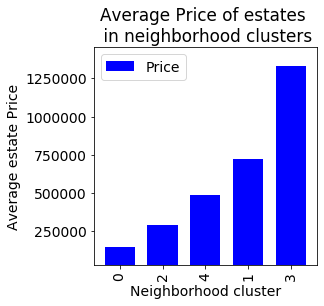

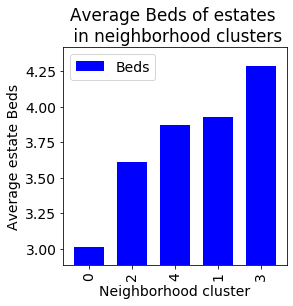

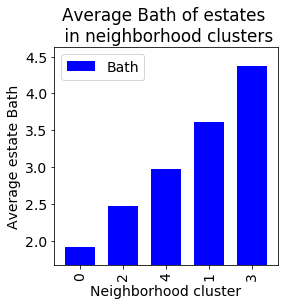

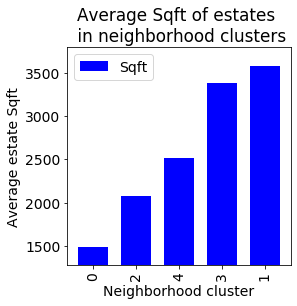

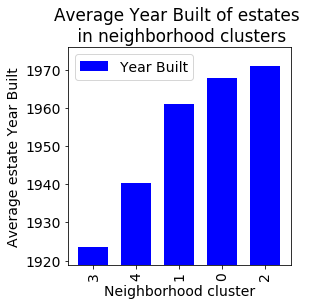

In [71]:
for col in estates_clustered.columns[1:]:
    ax = estates_clustered.sort_values(col).plot(kind='bar',
                               x='Cluster Labels',
                               y=col,
                               figsize=(4,4),
                               width=0.7,
                               color='b'
                               )
    # get range of y values
    y_range = estates_clustered[col].max() - estates_clustered[col].min()
    low = estates_clustered[col].min() - y_range*0.10
    high = estates_clustered[col].max() + y_range*0.10
    ax.set_ylim(bottom=low)
    ax.set_ylim(top=high)
    ax.set_title('Average {} of estates \n in neighborhood clusters'.format(col))
    ax.set_xlabel('Neighborhood cluster')
    ax.set_ylabel('Average estate {}'.format(col))
    plt.show

We can classify the neighborhood clusters as follow:  
Cluster 0 = small newer estates with about 3 beds and sale price about 148K USD.  
Cluster 2 = small-medium newer estates with about 3.6 beds and sale price about 291K USD.  
Cluster 4 = medium older estates with about 3.9 beds and sale price about 485K USD.  
Cluster 1 = medium-large estates with about 4 beds and sale price about 723K USD.  
Cluster 3 = large older estates with about 4.3 beds and sale price about 1.3 million USD.  

It is understandable that estates sale prices correspond with their size, however we can check to see if there is a corelation between estates' year built and their price.

In [60]:
# generate dataframe of yearbuilt vs price per square feet
estates_new.reset_index(inplace=True, drop=True)
p_sqft = estates_new['Price']/estates_new['Sqft']
df_py = pd.concat([estates_new['Year Built'], p_sqft], ignore_index=True, axis=1)
df_py.columns = ['Year Built', 'Price_per_sqft']

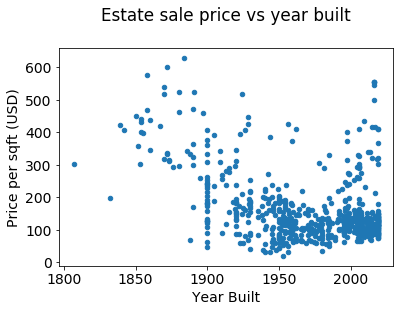

In [61]:
# scatter plot of estate year built and price
ax = df_py.plot(kind='scatter',
                    x='Year Built',
                    y='Price_per_sqft'
                    )
ax.set_ylabel('Price per sqft (USD)')
ax.set_title('Estate sale price vs year built', y=1.1)
ax.ticklabel_format(style='plain', axis='y', scilimits=(0,0))

From the scatter plot, it seems that there are two regions: a) upto 1960 and b) from 1960 to present

**How about average school rating near an estate?**

In [64]:
estates_new.reset_index(inplace=True, drop=True)
# calculate price per sqft
p_sqft = estates_new['Price']/estates_new['Sqft']

rating_avg = []

for school in estates_new['School Ratings']:
    r = school.split(',')
    # convert strings in list to integer
    r = [int(i) for i in r]
    r_avg = sum(r)/len(r)
    rating_avg.append(r_avg)

s_avg = pd.Series(rating_avg)
df_pr = pd.concat([p_sqft, s_avg], ignore_index=True, axis=1)
df_pr.columns = ['Price_per_sqft', 'Average Rating']

In [65]:
df_pr.head()

,Price_per_sqft,Average Rating
0,127.400768,2.000000
1,113.065693,2.666667
2,108.259824,3.500000
3,90.747230,3.500000
4,95.111940,3.500000


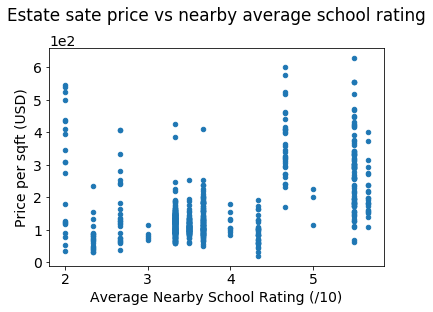

In [72]:
ax = df_pr.plot(kind='scatter',
               x='Average Rating',
               y='Price_per_sqft'
               )
ax.set_ylabel('Price per sqft (USD)')
ax.set_xlabel('Average Nearby School Rating (/10)')
ax.set_title('Estate sate price vs nearby average school rating', y=1.1)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

From the above scatter plot, there seems to be no correlation between the estates' sale price and their average surrounding school ratings.

# Results and discussion <a name='Results'></a>
Regarding the city venues, our k-mean clustering analysis shows that there is only a weak evidence of clustering in the data set based on the distortion and inertias plots. That is the different type of venues seems to distribute rather evenly within the city instead of segregating in different areas. Most of the venues in the city are social and food venues which are distributed evenly. Nevertheless, there seems a be a weak "elbow" at k = 4, which I used for the clustering procedure. The lack of venues clustering is understandable since Savannah, GA is not a very big city. It has a total population of about 146,000, which is magnitude less than the population of big city such as Toronto (2.8 million) and Chicago (2.7 million). Therefore, the amount of venues in Savannah is also alot less, which leads to a lesser degree of business competition and segregation.   
As expected, the number of venues is most densely populated in downtown Savannah, that is the South Historic District and North Historic District neighborhoods. While food and social venues distirbute evenly within the city, those who prefer park and recreations might like to reside toward the north and north-east side of the city. Golf enthusiast can find a few golf courts on the east side of the city.  
Interestingly, estates sale prices analysis using k-mean clustering shows a clear evidence of clustering with k = 5. The neighborhoods segregate into 5 different groups with different range of estates sale prices and estate sizes. The most expensive, largest, and oldest estates locate in the downtown area in the South Historic District. On the other hands, newer estates were built away from the downtown area and are generally smaller and cheaper in price. As expected, estates sale prices appears to correlate linearly with the number of bedrooms, bathrooms, and square feet. Interestingly, from the price_per_sqft vs year built plot we see that there two different trend presents. The first trend is that estates built before 1960 appears to have decreasing sale prices for newer estates (upto about 1960). The second trend is for estates built from 1960 to present. In this case ,the estates sale prices per sqft remains rather flat. On the other hand, there seems to be no correlation between estates sale prices and the nearby school ratings. This means family can choose to settle in an area with lower house cost but will have good schools nearby for their children.



# Conclusion <a name='Conclusion'></a>

This report provides an analysis of venues and estates sale prices in the city of Savannah, Georgia. Current and future city residents can use this information helps aid them in making a good decision about where to live which suits their price range, live style. In addition, city leaders can use this information to aid in managing their city more effectively.